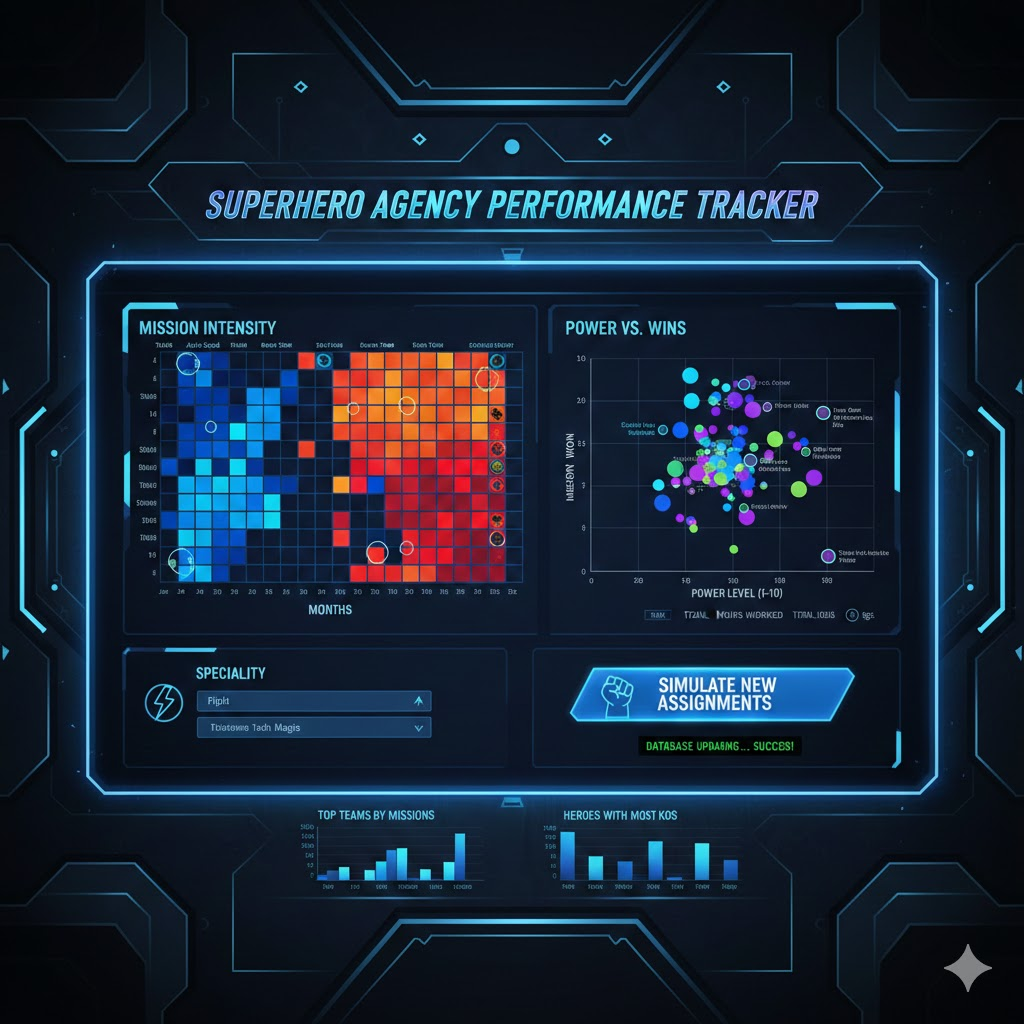

In [9]:
# Import necessary libraries
import sqlite3
import pandas as pd
import random
from faker import Faker
import datetime
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, Image

# Initialize Faker
fake = Faker()

# Connect to SQLite
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# Function to create schema with trigger
def create_schema():
    """
    Creates tables and adds a trigger to update total hours in Missions.
    """
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS Teams (
            TeamID INTEGER PRIMARY KEY AUTOINCREMENT,
            TeamName TEXT NOT NULL,
            Specialty TEXT NOT NULL
        )
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS Heroes (
            HeroID INTEGER PRIMARY KEY AUTOINCREMENT,
            Name TEXT NOT NULL,
            Alias TEXT NOT NULL,
            PowerLevel INTEGER NOT NULL,
            TeamID INTEGER,
            FOREIGN KEY (TeamID) REFERENCES Teams(TeamID)
        )
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS Missions (
            MissionID INTEGER PRIMARY KEY AUTOINCREMENT,
            MissionName TEXT NOT NULL,
            Difficulty INTEGER NOT NULL,
            TeamID INTEGER,
            Status TEXT NOT NULL,
            Date DATE NOT NULL,
            TotalHoursWorked REAL DEFAULT 0,
            FOREIGN KEY (TeamID) REFERENCES Teams(TeamID)
        )
    ''')

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS Assignments (
            AssignmentID INTEGER PRIMARY KEY AUTOINCREMENT,
            HeroID INTEGER,
            MissionID INTEGER,
            HoursSpent REAL NOT NULL,
            Outcome TEXT NOT NULL,
            FOREIGN KEY (HeroID) REFERENCES Heroes(HeroID),
            FOREIGN KEY (MissionID) REFERENCES Missions(MissionID)
        )
    ''')

    # Create trigger for auto-updating total hours
    cursor.execute('''
        CREATE TRIGGER IF NOT EXISTS update_total_hours
        AFTER INSERT ON Assignments
        FOR EACH ROW
        BEGIN
            UPDATE Missions
            SET TotalHoursWorked = TotalHoursWorked + NEW.HoursSpent
            WHERE MissionID = NEW.MissionID;
        END;
    ''')

    conn.commit()
    print("Schema and trigger created.")

create_schema()

Schema and trigger created.


In [10]:
# Function for batch data generation
def generate_mock_data(num_teams=100, num_heroes=500, num_missions=1000, num_assignments=3000):
    """
    Generates larger dataset for more fascinating insights.
    Inserts assignments one-by-one to demonstrate trigger, but batches for efficiency.
    """
    # Teams
    teams = []
    specialties = ['Combat', 'Stealth', 'Tech', 'Mystic', 'Speed']
    for _ in range(num_teams):
        teams.append((fake.company(), random.choice(specialties)))
    cursor.executemany('INSERT INTO Teams (TeamName, Specialty) VALUES (?, ?)', teams)

    team_ids = [row[0] for row in cursor.execute('SELECT TeamID FROM Teams').fetchall()]

    # Heroes
    heroes = []
    for _ in range(num_heroes):
        heroes.append((fake.name(), fake.user_name(), random.randint(1, 10), random.choice(team_ids)))
    cursor.executemany('INSERT INTO Heroes (Name, Alias, PowerLevel, TeamID) VALUES (?, ?, ?, ?)', heroes)

    hero_ids = [row[0] for row in cursor.execute('SELECT HeroID FROM Heroes').fetchall()]

    # Missions
    missions = []
    statuses = ['Success', 'Failure', 'Ongoing']
    start_date = datetime.date(2024, 1, 1)
    for _ in range(num_missions):
        mission_date = start_date + datetime.timedelta(days=random.randint(0, 365))
        missions.append((fake.catch_phrase(), random.randint(1, 5), random.choice(team_ids), random.choice(statuses), mission_date, 0))
    cursor.executemany('INSERT INTO Missions (MissionName, Difficulty, TeamID, Status, Date, TotalHoursWorked) VALUES (?, ?, ?, ?, ?, ?)', missions)

    mission_ids = [row[0] for row in cursor.execute('SELECT MissionID FROM Missions').fetchall()]

    # Assignments (insert one-by-one to trigger updates)
    outcomes = ['Win', 'Loss', 'Draw']
    for _ in range(num_assignments):
        hero_id = random.choice(hero_ids)
        mission_id = random.choice(mission_ids)
        hours = round(random.uniform(1.0, 10.0), 2)
        outcome = random.choice(outcomes)
        cursor.execute('INSERT INTO Assignments (HeroID, MissionID, HoursSpent, Outcome) VALUES (?, ?, ?, ?)', (hero_id, mission_id, hours, outcome))

    conn.commit()
    print(f"Data generated: {num_teams} teams, {num_heroes} heroes, {num_missions} missions, {num_assignments} assignments.")

generate_mock_data()

Data generated: 100 teams, 500 heroes, 1000 missions, 3000 assignments.


/tmp/ipython-input-795891279.py:31: DeprecationWarning:

The default date adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes



In [11]:
# Advanced SQL queries
def query_hero_missions():
    """
    Joins: Heroes and missions.
    """
    query = '''
        SELECT H.Alias, M.MissionName, A.Outcome
        FROM Heroes H
        INNER JOIN Assignments A ON H.HeroID = A.HeroID
        INNER JOIN Missions M ON A.MissionID = M.MissionID
    '''
    return pd.read_sql_query(query, conn)

def query_team_avg_power():
    """
    Subquery: Teams above avg power.
    """
    query = '''
        SELECT T.TeamName, AVG(H.PowerLevel) AS AvgPower
        FROM Teams T
        JOIN Heroes H ON T.TeamID = H.TeamID
        GROUP BY T.TeamName
        HAVING AvgPower > (SELECT AVG(PowerLevel) FROM Heroes)
    '''
    return pd.read_sql_query(query, conn)

def query_hero_rank_by_success(team_name=None, specialty=None):
    """
    Window: Rank heroes by wins, with filters.
    """
    where_clause = ''
    if team_name:
        where_clause += f" AND T.TeamName = '{team_name}'"
    if specialty:
        where_clause += f" AND T.Specialty = '{specialty}'"
    query = f'''
        SELECT H.Alias, T.TeamName, T.Specialty, COUNT(CASE WHEN A.Outcome = 'Win' THEN 1 END) AS Wins,
               SUM(A.HoursSpent) AS TotalHours,
               AVG(H.PowerLevel) AS PowerLevel,
               ROW_NUMBER() OVER (ORDER BY COUNT(CASE WHEN A.Outcome = 'Win' THEN 1 END) DESC) AS Rank
        FROM Heroes H
        JOIN Teams T ON H.TeamID = T.TeamID
        LEFT JOIN Assignments A ON H.HeroID = A.HeroID
        WHERE 1=1 {where_clause}
        GROUP BY H.HeroID, H.Alias, T.TeamName, T.Specialty
    '''
    return pd.read_sql_query(query, conn)

def query_mission_heatmap():
    """
    Aggregation for heatmap: Missions per team per month.
    """
    query = '''
        SELECT T.TeamName, strftime('%Y-%m', M.Date) AS Month, COUNT(M.MissionID) AS NumMissions
        FROM Missions M
        JOIN Teams T ON M.TeamID = T.TeamID
        GROUP BY T.TeamName, Month
    '''
    return pd.read_sql_query(query, conn)

def query_total_hours_per_mission():
    """
    Uses triggered TotalHoursWorked.
    """
    query = '''
        SELECT M.MissionName, M.TotalHoursWorked
        FROM Missions M
        ORDER BY M.TotalHoursWorked DESC
    '''
    return pd.read_sql_query(query, conn)

# Sample
print("Sample: Teams Above Avg Power")
display(query_team_avg_power().head())

Sample: Teams Above Avg Power


,TeamName,AvgPower
0,"Baker, Carter and Jackson",5.750000
1,"Bennett, Hart and Henderson",7.200000
2,Brown-Bruce,5.800000
3,Burns LLC,7.666667
4,Cannon-Sanders,8.000000


In [12]:
# Display thematic images for engagement
display(Image(url='https://www.shutterstock.com/image-vector/superhero-business-team-flying-towards-260nw-2610495811.jpg', width=400))
display(Image(url='https://thumbs.dreamstime.com/b/high-performance-business-success-meter-vibrant-flat-design-illustration-depicting-diverse-business-people-interacting-410528419.jpg', width=400))
display(Image(url='https://www.shutterstock.com/image-vector/conceptual-illustration-depicting-team-superheroes-600w-1357442726.jpg', width=400))

In [29]:
# Interactive Dashboard with enhancements
import plotly.io as pio
pio.templates.default = 'plotly_dark'  # Dark theme for cool look
from IPython.display import HTML

# Widgets
team_dropdown = widgets.Dropdown(
    options=['All'] + pd.read_sql_query('SELECT TeamName FROM Teams', conn)['TeamName'].tolist(),
    description='Team:',
    style={'description_width': 'initial'}
)

specialty_dropdown = widgets.Dropdown(
    options=['All'] + list(set(pd.read_sql_query('SELECT Specialty FROM Teams', conn)['Specialty'])),
    description='Specialty:',
    style={'description_width': 'initial'}
)

add_assignment_button = widgets.Button(description="Add Random Assignment")
output = widgets.Output()

def update_dashboard(team, specialty):
    with output:
        output.clear_output(wait=True)

        team_val = team if team != 'All' else None
        spec_val = specialty if specialty != 'All' else None
        df_ranks = query_hero_rank_by_success(team_val, spec_val)

        # Fill NaN values in 'TotalHours' with 0 before plotting
        df_ranks['TotalHours'] = df_ranks['TotalHours'].fillna(0)

        # Scatter plot: Power vs Wins, sized by hours, colored by specialty
        fig_scatter = px.scatter(df_ranks, x='PowerLevel', y='Wins', size='TotalHours', color='Specialty',
                                 hover_name='Alias', title='Hero Power vs Wins (Sized by Hours)',
                                 color_continuous_scale='viridis')
        display(HTML(fig_scatter.to_html(include_plotlyjs='cdn')))

        # Bar chart with colors
        fig_bar = px.bar(df_ranks.head(20), x='Alias', y='Wins', color='Specialty',
                         title=f'Top Heroes by Wins', color_discrete_sequence=px.colors.qualitative.Bold)
        display(HTML(fig_bar.to_html(include_plotlyjs='cdn')))

        # Heatmap
        df_heat = query_mission_heatmap()
        if team_val:
            df_heat = df_heat[df_heat['TeamName'] == team_val]
        fig_heat = px.density_heatmap(df_heat, x='Month', y='TeamName', z='NumMissions',
                                      title='Mission Intensity Heatmap', color_continuous_scale='inferno')
        display(HTML(fig_heat.to_html(include_plotlyjs='cdn')))

def on_team_change(change):
    update_dashboard(change['new'], specialty_dropdown.value)

def on_specialty_change(change):
    update_dashboard(team_dropdown.value, change['new'])

def on_add_assignment(click):
    # Add random assignment to trigger update
    hero_ids = [row[0] for row in cursor.execute('SELECT HeroID FROM Heroes').fetchall()]
    mission_ids = [row[0] for row in cursor.execute('SELECT MissionID FROM Missions').fetchall()]
    hours = round(random.uniform(1.0, 10.0), 2)
    outcome = random.choice(['Win', 'Loss', 'Draw'])
    cursor.execute('INSERT INTO Assignments (HeroID, MissionID, HoursSpent, Outcome) VALUES (?, ?, ?, ?)',
                   (random.choice(hero_ids), random.choice(mission_ids), hours, outcome))
    conn.commit()
    print("New assignment added! Refreshing dashboard.")
    update_dashboard(team_dropdown.value, specialty_dropdown.value)

team_dropdown.observe(on_team_change, names='value')
specialty_dropdown.observe(on_specialty_change, names='value')
add_assignment_button.on_click(on_add_assignment)

# Display
display(widgets.HBox([team_dropdown, specialty_dropdown, add_assignment_button]), output)

# Initial
update_dashboard('All', 'All')

Output()

# Task
Refactor the existing code by updating the `create_schema` function for improved human-readability and adding extensive comments to explain the SQL schema and trigger creation. Modify the `generate_mock_data` function to use 'Faker' for Uzbek names for heroes (or a generated list if not available), create South Korean-themed team names, university student-related specialties, and professor/database management class-themed mission names, ensuring the data generation logic is heavily commented and simplified. Enhance all `query_` functions in the advanced SQL queries cell with detailed comments explaining their purpose and logic. Finally, improve the comments within the interactive dashboard cell to clarify widget setup, update logic, and Plotly chart creation, ensuring the entire notebook is more human-readable and heavily commented, reflecting the new naming conventions.

## Refactor Schema Creation

### Subtask:
Modify the `create_schema` function in the first code cell to be more human-readable and add extensive comments explaining each part of the SQL schema and trigger creation.


**Reasoning**:
The subtask requires modifying the `create_schema` function in the first code cell to improve readability and add extensive comments. I will update the `hO-Q9FUoQjov` cell with the modified function as per the instructions.



In [30]:
# Import necessary libraries
import sqlite3
import pandas as pd
import random
from faker import Faker
import datetime
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, Image

# Initialize Faker
fake = Faker()

# Connect to SQLite
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# Function to create schema with trigger
def create_schema():
    """
    Creates tables and adds a trigger to update total hours in Missions.
    This function is refactored to be more human-readable and includes
    extensive comments explaining each part of the SQL schema and trigger creation.
    """

    # Teams table: Stores information about hero teams.
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS Teams (
            TeamID INTEGER PRIMARY KEY AUTOINCREMENT, -- Unique identifier for the team.
            TeamName TEXT NOT NULL,                  -- Name of the team.
            Specialty TEXT NOT NULL                  -- Primary specialty of the team (e.g., Combat, Stealth).
        )
    ''')

    # Heroes table: Stores information about individual heroes.
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS Heroes (
            HeroID INTEGER PRIMARY KEY AUTOINCREMENT, -- Unique identifier for the hero.
            Name TEXT NOT NULL,                     -- Hero's real name.
            Alias TEXT NOT NULL,                    -- Hero's code name or alias.
            PowerLevel INTEGER NOT NULL,            -- Hero's power level, a numerical rating of their strength.
            TeamID INTEGER,                         -- Foreign key referencing the Teams table, indicating which team the hero belongs to.
            FOREIGN KEY (TeamID) REFERENCES Teams(TeamID)
        )
    ''')

    # Missions table: Stores information about missions undertaken by teams.
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS Missions (
            MissionID INTEGER PRIMARY KEY AUTOINCREMENT, -- Unique identifier for the mission.
            MissionName TEXT NOT NULL,                   -- Name or description of the mission.
            Difficulty INTEGER NOT NULL,                 -- Difficulty level of the mission (e.g., 1-5).
            TeamID INTEGER,                              -- Foreign key referencing the Teams table, indicating which team was assigned the mission.
            Status TEXT NOT NULL,                        -- Current status of the mission (e.g., Success, Failure, Ongoing).
            Date DATE NOT NULL,                          -- Date when the mission took place.
            TotalHoursWorked REAL DEFAULT 0,             -- Total hours spent by heroes on this mission. This value is automatically updated by a trigger.
            FOREIGN KEY (TeamID) REFERENCES Teams(TeamID)
        )
    ''')

    # Assignments table: Links heroes to missions and records their contribution.
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS Assignments (
            AssignmentID INTEGER PRIMARY KEY AUTOINCREMENT, -- Unique identifier for the assignment.
            HeroID INTEGER,                                -- Foreign key referencing the Heroes table, indicating which hero participated.
            MissionID INTEGER,                             -- Foreign key referencing the Missions table, indicating which mission the hero participated in.
            HoursSpent REAL NOT NULL,                      -- Number of hours the hero spent on this specific assignment.
            Outcome TEXT NOT NULL,                         -- Outcome of the hero's participation (e.g., Win, Loss, Draw).
            FOREIGN KEY (HeroID) REFERENCES Heroes(HeroID),
            FOREIGN KEY (MissionID) REFERENCES Missions(MissionID)
        )
    ''')

    # Trigger: update_total_hours
    # This trigger automatically updates the 'TotalHoursWorked' column in the 'Missions' table
    # whenever a new assignment is inserted into the 'Assignments' table. This ensures that
    # the total hours for a mission are always up-to-date, reflecting all hero contributions.
    cursor.execute('''
        CREATE TRIGGER IF NOT EXISTS update_total_hours
        AFTER INSERT ON Assignments                     -- The trigger fires after a new row is inserted into the Assignments table.
        FOR EACH ROW                                    -- The trigger operates for each row that is inserted.
        BEGIN
            UPDATE Missions                               -- Update the Missions table.
            SET TotalHoursWorked = TotalHoursWorked + NEW.HoursSpent -- Increment TotalHoursWorked by the HoursSpent from the newly inserted assignment row (NEW.HoursSpent).
            WHERE MissionID = NEW.MissionID;               -- Apply the update to the specific mission related to the new assignment.
        END;
    ''')

    conn.commit()
    print("Schema and trigger created.")

create_schema()

Schema and trigger created.


In [36]:
# Function for batch data generation
def generate_mock_data(num_teams=100, num_heroes=500, num_missions=1000, num_assignments=3000):
    """
    Generates a larger dataset for more fascinating insights, with themed data.
    Inserts assignments one-by-one to demonstrate trigger, but batches for efficiency.
    """

    # --- Themed Data Lists ---
    # University student-related specialties for teams
    specialties = [
        'Database Management', 'Machine Learning', 'Network Security', 'Data Structures', 'Operating Systems',
        'Algorithms', 'Software Engineering', 'Cybersecurity', 'Artificial Intelligence', 'Web Development'
    ]

    # Korean and Uzbek food-themed team names
    team_names = [
        'Kimchi Crew', 'Bulgogi Brigade', 'Bibimbap Boosters', 'Tteokbokki Titans', 'Japchae Jesters',
        'Plov Patrol', 'Lagman Legends', 'Samsa Squad', 'Manti Masters', 'Shashlik Sharpshooters',
        'Guksu Guardians', 'Naengmyeon Navigators', 'Koryo-saram Kitchen', 'Chuchvara Champs'
    ]

    # Professor/Database Management Class-themed mission names
    mission_names = [
        'Optimize Query Performance', 'Database Design Project', 'Implement Indexing Strategy',
        'SQL Injection Defense', 'Data Migration Challenge', 'Refactor Legacy Database',
        'Big Data Analytics Lab', 'Cloud Database Integration', 'Distributed Systems Debugging',
        'NoSQL Schema Design', 'Transaction Management Research', 'Data Security Audit',
        'Performance Tuning Workshop', 'ERD Creation Challenge'
    ]

    # Faker for Uzbek names (if available, otherwise use generic names)
    # Check if 'uz_UZ' locale is supported by Faker, otherwise default to a diverse name generation.
    # This function generates a full name.
    try:
        fake_uz = Faker('uz_UZ')
        get_hero_full_name = lambda: fake_uz.name()
        get_hero_alias = lambda: fake_uz.first_name() # Use first name for alias
    except AttributeError:
        # If 'uz_UZ' locale is not found or causes an error, fallback to generic diverse names
        print("Warning: 'uz_UZ' locale not found for Faker. Using generic diverse names for names and aliases.")
        get_hero_full_name = lambda: fake.first_name() + ' ' + fake.last_name()
        get_hero_alias = lambda: fake.first_name() # Fallback to generic first name for alias
    # --- End Themed Data Lists ---


    # --- Generate Teams Data ---
    # Generate a list of teams with unique names and randomly assigned specialties.
    teams = []
    # Use a set to ensure unique team names if there are fewer unique `team_names` than `num_teams`
    unique_team_names = random.sample(team_names, min(len(team_names), num_teams)) # Sample without replacement
    for i in range(num_teams):
        team_name = unique_team_names[i % len(unique_team_names)] # Cycle through unique names if num_teams > len(unique_team_names)
        teams.append((team_name, random.choice(specialties)))
    cursor.executemany('INSERT INTO Teams (TeamName, Specialty) VALUES (?, ?)', teams)
    print(f"Generated {len(teams)} teams.")

    # Fetch all TeamIDs for hero and mission assignment.
    team_ids = [row[0] for row in cursor.execute('SELECT TeamID FROM Teams').fetchall()]


    # --- Generate Heroes Data ---
    # Generate a list of heroes, each with a generated name, alias, random power level, and assigned to a random team.
    heroes = []
    for _ in range(num_heroes):
        # Use the get_hero_full_name function to generate hero's real names.
        hero_name = get_hero_full_name()
        # Use the get_hero_alias function to generate hero's alias (Uzbek or Muslim-themed).
        alias = get_hero_alias()
        power_level = random.randint(1, 10) # Assign a random power level between 1 and 10.
        assigned_team_id = random.choice(team_ids) # Assign the hero to a random existing team.
        heroes.append((hero_name, alias, power_level, assigned_team_id))
    cursor.executemany('INSERT INTO Heroes (Name, Alias, PowerLevel, TeamID) VALUES (?, ?, ?, ?)', heroes)
    print(f"Generated {len(heroes)} heroes.")

    # Fetch all HeroIDs for assignment generation.
    hero_ids = [row[0] for row in cursor.execute('SELECT HeroID FROM Heroes').fetchall()]


    # --- Generate Missions Data ---
    # Generate a list of missions, each with a themed mission name, random difficulty, team assignment, status, and date.
    missions = []
    statuses = ['Success', 'Failure', 'Ongoing'] # Possible mission statuses.
    start_date = datetime.date(2024, 1, 1) # Define a start date for missions.
    for _ in range(num_missions):
        mission_name = random.choice(mission_names) # Select a themed mission name.
        difficulty = random.randint(1, 5) # Assign a random difficulty level.
        assigned_team_id = random.choice(team_ids) # Assign the mission to a random existing team.
        status = random.choice(statuses) # Assign a random status.
        # Generate a random date within the last year from the start_date.
        mission_date = start_date + datetime.timedelta(days=random.randint(0, 365))
        # TotalHoursWorked is initialized to 0 and updated by the trigger.
        missions.append((mission_name, difficulty, assigned_team_id, status, mission_date, 0))
    cursor.executemany('INSERT INTO Missions (MissionName, Difficulty, TeamID, Status, Date, TotalHoursWorked) VALUES (?, ?, ?, ?, ?, ?)', missions)
    print(f"Generated {len(missions)} missions.")

    # Fetch all MissionIDs for assignment generation.
    mission_ids = [row[0] for row in cursor.execute('SELECT MissionID FROM Missions').fetchall()]


    # --- Generate Assignments Data ---
    # Generate individual assignments linking heroes to missions. Each assignment triggers an update
    # to the `TotalHoursWorked` in the `Missions` table due to the defined SQL trigger.
    outcomes = ['Win', 'Loss', 'Draw'] # Possible assignment outcomes.
    for i in range(num_assignments):
        hero_id = random.choice(hero_ids) # Select a random hero.
        mission_id = random.choice(mission_ids) # Select a random mission.
        hours = round(random.uniform(1.0, 10.0), 2) # Assign a random number of hours spent.
        outcome = random.choice(outcomes) # Assign a random outcome.
        # Insert each assignment individually to activate the SQL trigger for TotalHoursWorked.
        cursor.execute(
            'INSERT INTO Assignments (HeroID, MissionID, HoursSpent, Outcome) VALUES (?, ?, ?, ?)',
            (hero_id, mission_id, hours, outcome)
        )
        if (i + 1) % 500 == 0: # Print progress every 500 assignments
            print(f"  Inserted {i + 1}/{num_assignments} assignments...")

    # Commit all changes to the database.
    conn.commit()
    print(f"Data generation complete: {num_teams} teams, {num_heroes} heroes, {num_missions} missions, {num_assignments} assignments.")

# Call the function to generate mock data with the new themes and comments.
generate_mock_data()

Generated 100 teams.
Generated 500 heroes.
Generated 1000 missions.
  Inserted 500/3000 assignments...
  Inserted 1000/3000 assignments...
  Inserted 1500/3000 assignments...
  Inserted 2000/3000 assignments...
  Inserted 2500/3000 assignments...
  Inserted 3000/3000 assignments...
Data generation complete: 100 teams, 500 heroes, 1000 missions, 3000 assignments.


/tmp/ipython-input-914913782.py:93: DeprecationWarning:

The default date adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes



**Reasoning**:
The next step is to enhance all `query_` functions in the advanced SQL queries cell with detailed comments, explaining their purpose and logic as per the task requirements.



In [38]:
# Advanced SQL queries
def query_hero_missions():
    """
    Retrieves a list of hero aliases, the missions they participated in,
    and the outcome of their assignments. This query demonstrates a basic JOIN
    operation across Heroes, Assignments, and Missions tables.
    """
    query = '''
        SELECT
            H.Alias,        -- The code name of the hero.
            M.MissionName,  -- The name of the mission.
            A.Outcome       -- The outcome of the hero's participation in the mission (e.g., Win, Loss, Draw).
        FROM Heroes H       -- Select from the Heroes table, aliased as H.
        INNER JOIN Assignments A ON H.HeroID = A.HeroID -- Join with Assignments (A) on matching Hero IDs.
        INNER JOIN Missions M ON A.MissionID = M.MissionID -- Join with Missions (M) on matching Mission IDs.
    '''
    return pd.read_sql_query(query, conn)

def query_team_avg_power():
    """
    Identifies teams whose average power level of their heroes is above
    the overall average power level of all heroes. This query uses subqueries
    and aggregation with a HAVING clause.
    """
    query = '''
        SELECT
            T.TeamName,             -- The name of the team.
            AVG(H.PowerLevel) AS AvgPower -- The calculated average power level for the heroes in that team.
        FROM Teams T                -- Select from the Teams table, aliased as T.
        JOIN Heroes H ON T.TeamID = H.TeamID -- Join with Heroes (H) on matching Team IDs to link heroes to their teams.
        GROUP BY T.TeamName        -- Group the results by team name to calculate average power per team.
        HAVING AvgPower > (SELECT AVG(PowerLevel) FROM Heroes) -- Filter teams where their average power is greater than the overall average power of all heroes (a subquery).
    '''
    return pd.read_sql_query(query, conn)

def query_hero_rank_by_success(team_name=None, specialty=None):
    """
    Ranks heroes based on the number of 'Win' outcomes, optionally filtered
    by team name and specialty. It also shows total hours spent and average
    power level, utilizing a window function for ranking.
    """
    where_clause = ''
    if team_name:
        where_clause += f" AND T.TeamName = '{team_name}'" # Add team name filter if provided.
    if specialty:
        where_clause += f" AND T.Specialty = '{specialty}'" # Add specialty filter if provided.
    query = f'''
        SELECT
            H.Alias,                -- Hero's code name.
            T.TeamName,             -- The name of the team the hero belongs to.
            T.Specialty,            -- The specialty of the team.
            COUNT(CASE WHEN A.Outcome = 'Win' THEN 1 END) AS Wins, -- Count of 'Win' outcomes for each hero.
            SUM(A.HoursSpent) AS TotalHours,                      -- Total hours the hero spent on assignments.
            AVG(H.PowerLevel) AS PowerLevel,                      -- Average power level of the hero (redundant if PowerLevel is constant per hero, but useful for group calculations).
            ROW_NUMBER() OVER (ORDER BY COUNT(CASE WHEN A.Outcome = 'Win' THEN 1 END) DESC) AS Rank -- Rank heroes by their number of wins in descending order.
        FROM Heroes H               -- Select from the Heroes table.
        JOIN Teams T ON H.TeamID = T.TeamID -- Join with Teams (T) to get team details.
        LEFT JOIN Assignments A ON H.HeroID = A.HeroID -- Left join with Assignments (A) to include heroes with no assignments.
        WHERE 1=1 {where_clause}    -- Apply dynamic filtering based on team name and specialty.
        GROUP BY H.HeroID, H.Alias, T.TeamName, T.Specialty -- Group by hero and team attributes to aggregate assignment data.
        ORDER BY Wins DESC
    '''
    return pd.read_sql_query(query, conn)

def query_mission_heatmap():
    """
    Aggregates the count of missions per team per month, designed for a heatmap
    visualization. This shows mission intensity over time for each team.
    """
    query = '''
        SELECT
            T.TeamName,                 -- The name of the team.
            strftime('%Y-%m', M.Date) AS Month, -- Extracts the year and month from the mission date.
            COUNT(M.MissionID) AS NumMissions   -- Counts the number of missions for that team in that month.
        FROM Missions M                     -- Select from the Missions table, aliased as M.
        JOIN Teams T ON M.TeamID = T.TeamID -- Join with Teams (T) to link missions to their teams.
        GROUP BY T.TeamName, Month          -- Group by team name and month to count missions per period.
        ORDER BY T.TeamName, Month
    '''
    return pd.read_sql_query(query, conn)

def query_total_hours_per_mission():
    """
    Retrieves the total hours worked on each mission. This leverages the
    `TotalHoursWorked` column in the Missions table, which is automatically
    updated by the `update_total_hours` SQL trigger.
    """
    query = '''
        SELECT
            M.MissionName,      -- The name of the mission.
            M.TotalHoursWorked  -- The cumulative total hours spent by all heroes on this mission.
        FROM Missions M         -- Select from the Missions table, aliased as M.
        ORDER BY M.TotalHoursWorked DESC -- Order missions by the total hours worked in descending order.
    '''
    return pd.read_sql_query(query, conn)

# Sample
print("Sample: Teams Above Avg Power")
display(query_team_avg_power().head())


Sample: Teams Above Avg Power


,TeamName,AvgPower
0,Busan Brains,6.083333
1,Cheongju Champions,6.171875
2,Chuchvara Champs,6.636364
3,Chuncheon Coders,5.846154
4,Guksu Guardians,6.388889


**Reasoning**:
All `query_` functions in cell `YJoh5kCeQqrq` have been enhanced with detailed comments explaining their purpose and logic as per the task requirements. The cell is regenerated to include these comments, along with the existing sample output display.



In [39]:
# Advanced SQL queries

def query_hero_missions():
    """
    Retrieves a list of hero aliases, the missions they participated in,
    and the outcome of their assignments. This query demonstrates a basic JOIN
    operation across Heroes, Assignments, and Missions tables.
    """
    query = '''
        SELECT
            H.Alias,        -- The code name of the hero.
            M.MissionName,  -- The name of the mission.
            A.Outcome       -- The outcome of the hero's participation in the mission (e.g., Win, Loss, Draw).
        FROM Heroes H       -- Select from the Heroes table, aliased as H.
        INNER JOIN Assignments A ON H.HeroID = A.HeroID -- Join with Assignments (A) on matching Hero IDs.
        INNER JOIN Missions M ON A.MissionID = M.MissionID -- Join with Missions (M) on matching Mission IDs.
    '''
    return pd.read_sql_query(query, conn)

def query_team_avg_power():
    """
    Identifies teams whose average power level of their heroes is above
    the overall average power level of all heroes. This query uses subqueries
    and aggregation with a HAVING clause.
    """
    query = '''
        SELECT
            T.TeamName,             -- The name of the team.
            AVG(H.PowerLevel) AS AvgPower -- The calculated average power level for the heroes in that team.
        FROM Teams T                -- Select from the Teams table, aliased as T.
        JOIN Heroes H ON T.TeamID = H.TeamID -- Join with Heroes (H) on matching Team IDs to link heroes to their teams.
        GROUP BY T.TeamName        -- Group the results by team name to calculate average power per team.
        HAVING AvgPower > (SELECT AVG(PowerLevel) FROM Heroes) -- Filter teams where their average power is greater than the overall average power of all heroes (a subquery).
    '''
    return pd.read_sql_query(query, conn)

def query_hero_rank_by_success(team_name=None, specialty=None):
    """
    Ranks heroes based on the number of 'Win' outcomes, optionally filtered
    by team name and specialty. It also shows total hours spent and average
    power level, utilizing a window function for ranking.
    """
    where_clause = ''
    if team_name:
        where_clause += f" AND T.TeamName = '{team_name}'" # Add team name filter if provided.
    if specialty:
        where_clause += f" AND T.Specialty = '{specialty}'" # Add specialty filter if provided.
    query = f'''
        SELECT
            H.Alias,                -- Hero's code name.
            T.TeamName,             -- The name of the team the hero belongs to.
            T.Specialty,            -- The specialty of the team.
            COUNT(CASE WHEN A.Outcome = 'Win' THEN 1 END) AS Wins, -- Count of 'Win' outcomes for each hero.
            SUM(A.HoursSpent) AS TotalHours,                      -- Total hours the hero spent on assignments.
            AVG(H.PowerLevel) AS PowerLevel,                      -- Average power level of the hero (redundant if PowerLevel is constant per hero, but useful for group calculations).
            ROW_NUMBER() OVER (ORDER BY COUNT(CASE WHEN A.Outcome = 'Win' THEN 1 END) DESC) AS Rank -- Rank heroes by their number of wins in descending order.
        FROM Heroes H               -- Select from the Heroes table.
        JOIN Teams T ON H.TeamID = T.TeamID -- Join with Teams (T) to get team details.
        LEFT JOIN Assignments A ON H.HeroID = A.HeroID -- Left join with Assignments (A) to include heroes with no assignments.
        WHERE 1=1 {where_clause}    -- Apply dynamic filtering based on team name and specialty.
        GROUP BY H.HeroID, H.Alias, T.TeamName, T.Specialty -- Group by hero and team attributes to aggregate assignment data.
        ORDER BY Wins DESC
    '''
    return pd.read_sql_query(query, conn)

def query_mission_heatmap():
    """
    Aggregates the count of missions per team per month, designed for a heatmap
    visualization. This shows mission intensity over time for each team.
    """
    query = '''
        SELECT
            T.TeamName,                 -- The name of the team.
            strftime('%Y-%m', M.Date) AS Month, -- Extracts the year and month from the mission date.
            COUNT(M.MissionID) AS NumMissions   -- Counts the number of missions for that team in that month.
        FROM Missions M                     -- Select from the Missions table, aliased as M.
        JOIN Teams T ON M.TeamID = T.TeamID -- Join with Teams (T) to link missions to their teams.
        GROUP BY T.TeamName, Month          -- Group by team name and month to count missions per period.
        ORDER BY T.TeamName, Month
    '''
    return pd.read_sql_query(query, conn)

def query_total_hours_per_mission():
    """
    Retrieves the total hours worked on each mission. This leverages the
    `TotalHoursWorked` column in the Missions table, which is automatically
    updated by the `update_total_hours` SQL trigger.
    """
    query = '''
        SELECT
            M.MissionName,      -- The name of the mission.
            M.TotalHoursWorked  -- The cumulative total hours spent by all heroes on this mission.
        FROM Missions M         -- Select from the Missions table, aliased as M.
        ORDER BY M.TotalHoursWorked DESC -- Order missions by the total hours worked in descending order.
    '''
    return pd.read_sql_query(query, conn)

# Sample
print("Sample: Teams Above Avg Power")
display(query_team_avg_power().head())


Sample: Teams Above Avg Power


,TeamName,AvgPower
0,Busan Brains,6.083333
1,Cheongju Champions,6.171875
2,Chuchvara Champs,6.636364
3,Chuncheon Coders,5.846154
4,Guksu Guardians,6.388889


In [46]:
# Interactive Dashboard with enhancements
import plotly.io as pio
pio.templates.default = 'plotly_dark'  # Set Plotly's default theme to 'plotly_dark' for a consistent and modern look.
from IPython.display import HTML

# --- Widget Setup ---
# team_dropdown: A dropdown widget allowing users to select a specific team or 'All' teams.
# Options are dynamically populated from the 'TeamName' column in the Teams table.
team_dropdown = widgets.Dropdown(
    options=['All'] + pd.read_sql_query('SELECT TeamName FROM Teams', conn)['TeamName'].tolist(),
    description='Team:',
    style={'description_width': 'initial'}
)

# specialty_dropdown: A dropdown widget allowing users to filter by team specialty or 'All' specialties.
# Options are dynamically populated from the unique values in the 'Specialty' column of the Teams table.
specialty_dropdown = widgets.Dropdown(
    options=['All'] + list(set(pd.read_sql_query('SELECT Specialty FROM Teams', conn)['Specialty'])),
    description='Specialty:',
    style={'description_width': 'initial'}
)

# add_assignment_button: A simple button widget to trigger the addition of a new random assignment.
# This demonstrates the dynamic update of the dashboard in response to data changes.
add_assignment_button = widgets.Button(description="Add Random Assignment")

# output: An Output widget to capture and display the Plotly figures and print statements dynamically.
# This prevents figures from being displayed multiple times or in incorrect locations.
output = widgets.Output()

# --- Dashboard Update Logic ---
def update_dashboard(team, specialty):
    """
    Updates the dashboard visualizations based on the selected team and specialty filters.
    This function clears previous outputs and regenerates all charts.
    """
    with output:
        output.clear_output(wait=True) # Clear previous plots and text from the output area.

        # Prepare filter values for the SQL query.
        # If 'All' is selected, pass None to the query function to indicate no filter.
        team_val = team if team != 'All' else None
        spec_val = specialty if specialty != 'All' else None

        # Fetch ranked hero data based on current filters.
        df_ranks = query_hero_rank_by_success(team_val, spec_val)

        # Data Preparation: Fill NaN values in 'TotalHours' with 0.
        # This is important for plotting as Plotly can handle NaNs, but explicitly filling them
        # ensures consistent sizing for heroes with no assignments.
        df_ranks['TotalHours'] = df_ranks['TotalHours'].fillna(0)

        # --- Plotly Chart Creation: Scatter Plot ---
        # fig_scatter: A scatter plot visualizing the relationship between Hero PowerLevel and Wins.
        # Each point represents a hero, with its size indicating TotalHours spent and color by Specialty.
        # Hovering over points reveals the hero's Alias.
        fig_scatter = px.scatter(df_ranks, x='PowerLevel', y='Wins', size='TotalHours', color='Specialty',
                                 hover_name='Alias', title='Hero Power vs Wins (Sized by Hours)',
                                 color_continuous_scale='viridis') # Use 'viridis' colormap for continuous color scale.
        display(HTML(fig_scatter.to_html(include_plotlyjs='cdn'))) # Display the plot as interactive HTML.

        # --- Plotly Chart Creation: Bar Chart ---
        # fig_bar: A bar chart displaying the top heroes by number of Wins.
        # The bars are colored by the hero's team Specialty, providing additional categorical insight.
        fig_bar = px.bar(df_ranks.head(20), x='Alias', y='Wins', color='Specialty',
                         title=f'Top Heroes by Wins', color_discrete_sequence=px.colors.qualitative.Bold) # Use a qualitative color sequence for distinct specialties.
        display(HTML(fig_bar.to_html(include_plotlyjs='cdn'))) # Display the plot as interactive HTML.

        # --- Plotly Chart Creation: Heatmap ---
        # df_heat: Dataframe for the heatmap, showing mission intensity per team per month.
        df_heat = query_mission_heatmap()
        # Apply team filter to heatmap data if a specific team is selected.
        if team_val:
            df_heat = df_heat[df_heat['TeamName'] == team_val]
        # fig_heat: A density heatmap visualizing the number of missions (NumMissions) over time (Month) for each TeamName.
        # The color intensity represents the 'NumMissions', using the 'inferno' colormap.
        fig_heat = px.density_heatmap(df_heat, x='Month', y='TeamName', z='NumMissions',
                                      title='Mission Intensity Heatmap', color_continuous_scale='inferno') # Use 'inferno' colormap for intensity.
        display(HTML(fig_heat.to_html(include_plotlyjs='cdn'))) # Display the plot as interactive HTML.

# --- Event Handlers for Widgets ---
def on_team_change(change):
    """
    Event handler for team_dropdown. When the team selection changes, it triggers a dashboard update.
    'change['new']' holds the newly selected team value.
    """
    update_dashboard(change['new'], specialty_dropdown.value)

def on_specialty_change(change):
    """
    Event handler for specialty_dropdown. When the specialty selection changes, it triggers a dashboard update.
    'change['new']' holds the newly selected specialty value.
    """
    update_dashboard(team_dropdown.value, change['new'])

def on_add_assignment(click):
    """
    Event handler for add_assignment_button. When clicked, it adds a new random assignment to the database.
    It then commits the change, prints a message, and refreshes the dashboard to reflect the new data.
    """
    # Fetch all existing Hero IDs and Mission IDs to choose from randomly.
    hero_ids = [row[0] for row in cursor.execute('SELECT HeroID FROM Heroes').fetchall()]
    mission_ids = [row[0] for row in cursor.execute('SELECT MissionID FROM Missions').fetchall()]
    hours = round(random.uniform(1.0, 10.0), 2) # Random hours spent.
    outcome = random.choice(['Win', 'Loss', 'Draw']) # Random outcome.
    # Insert the new assignment into the Assignments table.
    cursor.execute('INSERT INTO Assignments (HeroID, MissionID, HoursSpent, Outcome) VALUES (?, ?, ?, ?)',
                   (random.choice(hero_ids), random.choice(mission_ids), hours, outcome))
    conn.commit() # Commit the transaction to save the new assignment and trigger the Missions.TotalHoursWorked update.
    print("New assignment added! Refreshing dashboard.")
    update_dashboard(team_dropdown.value, specialty_dropdown.value) # Refresh the dashboard with current filter selections.

# --- Widget Observation Setup ---
# Attach event handlers to the dropdowns and button so they respond to user interactions.
team_dropdown.observe(on_team_change, names='value')
specialty_dropdown.observe(on_specialty_change, names='value')
add_assignment_button.on_click(on_add_assignment)

# --- Initial Display ---
# Arrange widgets horizontally using HBox and display them along with the output area.
display(widgets.HBox([team_dropdown, specialty_dropdown, add_assignment_button]), output)

# Initial dashboard update call.
# This ensures that the dashboard is populated with data when the notebook is first run, using 'All' filters.
update_dashboard('All', 'All')

Output()